*Bộ dữ liệu **"Loan data"** liên quan đến các thông tin chi tiết về các khoản vay, bao gồm thông tin về người vay, chi tiết khoản vay, lịch sử trả nợ, và các thông tin liên quan đến ngân hàng hoặc tổ chức tài chính cấp vay,... Project này tiến hành phân tích liệu khoản vay đó có được "thanh toán đầy đủ" hay không. Với output là **Not_fully_paid**: với **1** mang ý nghĩa "chưa thanh toán", và **0** có nghĩa "đã thanh toán đầy đủ":*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict, GridSearchCV

#SMOTE
from imblearn.over_sampling import SMOTE

#Mô hình XG Boost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Decision tree
from sklearn.tree import DecisionTreeClassifier

#VIF để phát hiện đa cộng tuyến trong mô hình hồi quy.
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/loan_data.csv')
data

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,credit_card,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.000,0,0
1,1,home_improvement,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.000,0,0
2,1,credit_card,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.000,0,0
3,1,credit_card,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.000,0,0
4,1,debt_consolidation,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37061,1,debt_consolidation,0.088,792.79,167000.0,24.66,694,37895,0,0.000,25987,0.680,0,1
37062,1,debt_consolidation,0.103,856.40,125000.0,11.73,744,31444,0,0.000,1728,0.033,0,1
37063,1,small_business,0.180,837.45,75000.0,9.02,694,40878,3,0.000,636,0.038,0,1
37064,1,debt_consolidation,0.110,458.48,32072.0,58.12,779,39539,0,0.000,15016,0.289,0,1


**GIẢI THÍCH DỮ LIỆU:**

**Các trường thông tin bao gồm:**

**1.purpose:** Mục đích vay

**2.int_rate:** Lãi suất (%) cho khoản vay.

**3.installment:** Số tiền cố định trả hàng tháng (lãi+gốc)

**4.log_annual_inc:** Logarithm tự nhiên của thu nhập hàng năm

**5.dti:** Tỷ lệ nợ trên thu nhập (tổng số tiền nợ của người vay so với thu nhập hàng tháng).

**6.fico:** Điểm FICO, một loại điểm tín dụng được sử dụng để đánh giá rủi ro tín dụng của một cá nhân

**7.days_with_cr_line:** Số ngày từ khi người vay mở tài khoản

**8.revol_bal:** tiền nợ trên thẻ tín dụng

**9.revol_util:** Tỉ lệ sử dụng hạn mức tín dụng

**10.inq_last_6mths:** Số lần kiểm tra tín dụng 6 tháng gần đây.

**11.delinq_2yrs:** Số lần bị trễ nợ trong 2 năm qua.

**12.pub_rec:** Số lượng bản ghi công khai về nợ xấu

**13.not_fully_paid:** Output chỉ ra xem khoản vay đã được thanh toán hoàn toàn hay không, 1 là chưa thanh toán, 0 là đã thanh toán đầy đủ.

**A.DATA CHECKING**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37066 entries, 0 to 37065
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      37066 non-null  int64  
 1   purpose            37066 non-null  object 
 2   int_rate           37066 non-null  float64
 3   installment        37066 non-null  float64
 4   log_annual_inc     37066 non-null  float64
 5   dti                36966 non-null  float64
 6   fico               37066 non-null  int64  
 7   days_with_cr_line  37066 non-null  int64  
 8   revol_bal          37066 non-null  int64  
 9   revol_util         37054 non-null  float64
 10  inq_last_6mths     37066 non-null  int64  
 11  delinq_2yrs        37032 non-null  float64
 12  pub_rec            37066 non-null  int64  
 13  not_fully_paid     37066 non-null  int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 4.0+ MB


In [6]:
#Kiểm tra giá trị Null:
data.isnull().sum()

credit_policy          0
purpose                0
int_rate               0
installment            0
log_annual_inc         0
dti                  100
fico                   0
days_with_cr_line      0
revol_bal              0
revol_util            12
inq_last_6mths         0
delinq_2yrs           34
pub_rec                0
not_fully_paid         0
dtype: int64

In [7]:
#Số lượng này không quá nhiều, vì vậy ta có thể xóa ngay lập tức:
data = data.dropna()

**B.EDA**

*Vẽ biểu đồ mô tả một số columns, các columns còn lại tương tự*

***1.Not_fully_paid***

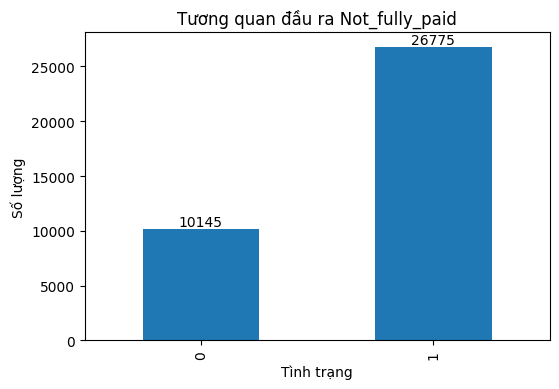

In [10]:
plt.figure(figsize=(6, 4))
ax = data.groupby("not_fully_paid").size().plot(kind='bar')

# Thêm số cụ thể lên đỉnh mỗi cột
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.title('Tương quan đầu ra Not_fully_paid')
plt.xlabel('Tình trạng')
plt.ylabel('Số lượng')
plt.show()

***2.Purpose***

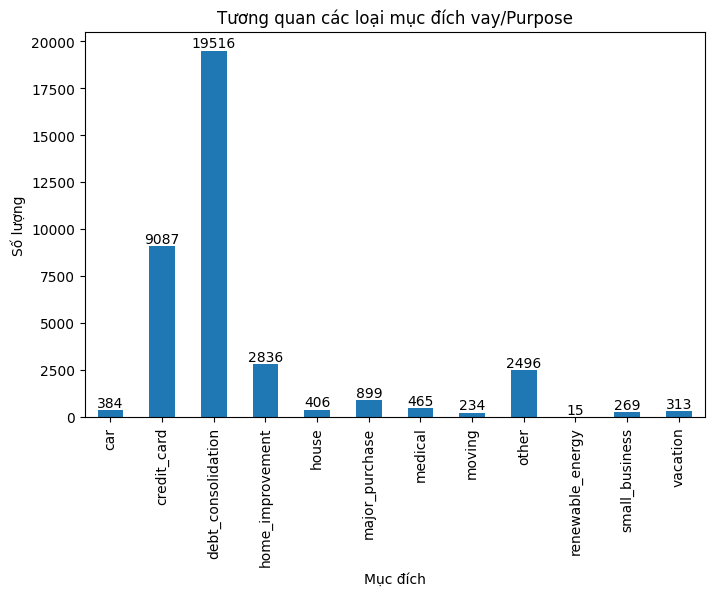

In [15]:
plt.figure(figsize=(8, 5))
ax = data.groupby("purpose").size().plot(kind='bar')

# Thêm số cụ thể lên đỉnh mỗi cột
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.title('Tương quan các loại mục đích vay/Purpose')
plt.xlabel('Mục đích')
plt.ylabel('Số lượng')
plt.show()

***3.FICO***

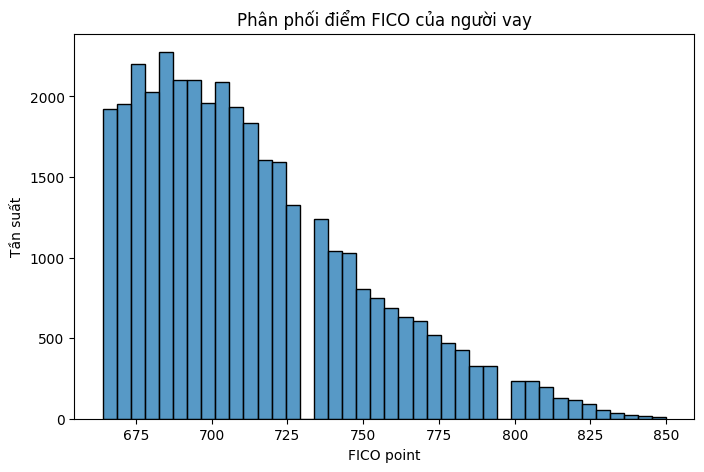

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(data['fico'], bins=40, edgecolor='black')
plt.title('Phân phối điểm FICO của người vay')
plt.xlabel('FICO point')
plt.ylabel('Tần suất')
plt.show()

**C.DATA PREPROCESSING**

***1.VIF cho các columns chứa thuộc tính số:***

In [22]:
# VIF cho các columns thuộc tính số:
num_cols = data.select_dtypes(exclude=['object'])
num_cols = num_cols.columns.tolist()

# Tạo DataFrame chứa các cột số
vif_data = data[num_cols]
remove_columns = []

# Tạo bản sao của num_col để theo dõi các cột đã giữ lại
remaining_columns = num_cols.copy()

for col in remaining_columns.copy():
    # Tính toán VIF cho cột hiện tại
    vif_value = variance_inflation_factor(vif_data.values, remaining_columns.index(col))
    print(f"Column ({col}) --- VIF: {vif_value}")

    if vif_value > 6:
        remove_columns.append(col)
    else:
      continue

# In ra các cột được giữ lại
print("Các columns cần được xóa:")
print(remove_columns)

Column (credit_policy) --- VIF: 968.671538944902
Column (int_rate) --- VIF: 1.3066289286853439
Column (installment) --- VIF: 1.1579212239321195
Column (log_annual_inc) --- VIF: 1.1437203480419682
Column (dti) --- VIF: 1.0656905406879418
Column (fico) --- VIF: 1.5207158706988007
Column (days_with_cr_line) --- VIF: 1.1028242065285452
Column (revol_bal) --- VIF: 1.3114322567714065
Column (revol_util) --- VIF: 1.0886371705063485
Column (inq_last_6mths) --- VIF: 1.286442685777712
Column (delinq_2yrs) --- VIF: 1.2055479532595421
Column (pub_rec) --- VIF: 1.077916182435874
Column (not_fully_paid) --- VIF: 1.1883045820530969
Các columns cần được xóa:
['credit_policy']


In [24]:
data = data.drop(columns = remove_columns)

***2.Encoding cho các columns Object***

In [26]:
label_encoders = {}
categorical_columns = data[['purpose']]
for col in categorical_columns:
    le = LabelEncoder()
    data.loc[:, col] = le.fit_transform(data[col])
    label_encoders[col] = le

***Corr-matrix***

In [28]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
purpose,1.000000,0.052783,-0.131950,-0.006057,-0.045985,0.073641,-0.006493,-0.049920,0.006317,-0.062559,-0.036251,0.008043,0.021721
int_rate,0.052783,1.000000,0.042739,-0.055919,0.116065,-0.456244,0.086726,0.021824,0.133468,-0.003504,0.172759,0.046075,-0.036599
installment,-0.131950,0.042739,1.000000,0.227242,0.084286,0.022387,-0.125390,0.170643,0.028539,0.226005,0.046695,-0.049956,-0.013016
log_annual_inc,-0.006057,-0.055919,0.227242,1.000000,-0.121779,0.020853,-0.119594,0.151355,0.044720,0.177392,0.029868,-0.034424,-0.037026
dti,-0.045985,0.116065,0.084286,-0.121779,1.000000,-0.013244,-0.044598,0.077765,0.000342,0.081434,0.032497,-0.010775,-0.031361
fico,0.073641,-0.456244,0.022387,0.020853,-0.013244,1.000000,-0.120728,-0.021722,-0.188516,-0.065700,-0.307689,-0.191167,-0.027124
days_with_cr_line,-0.006493,0.086726,-0.125390,-0.119594,-0.044598,-0.120728,1.000000,-0.066180,-0.068710,-0.187349,-0.052515,-0.006409,-0.038029
revol_bal,-0.049920,0.021824,0.170643,0.151355,0.077765,-0.021722,-0.066180,1.000000,0.128898,-0.203446,-0.146972,-0.067585,-0.356469
revol_util,0.006317,0.133468,0.028539,0.044720,0.000342,-0.188516,-0.068710,0.128898,1.000000,-0.061745,-0.014098,-0.052424,-0.086816
inq_last_6mths,-0.062559,-0.003504,0.226005,0.177392,0.081434,-0.065700,-0.187349,-0.203446,-0.061745,1.000000,0.220876,-0.056046,0.219629


**C.DATA PREDICTION**

*Trong phần này, ta sẽ tiến hành training bằng các mô hình Classification thuần túy, tiếp theo là các phương pháp Upsampling,... để tìm xem mô hình nào có hiệu suất tốt nhất*

In [31]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

In [33]:
#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(df, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = df.drop(columns=['not_fully_paid'], axis=1)
    y = df['not_fully_paid']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # MinMax Scaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

***1.Logistic Regression:*** Hiệu suất không cao

In [34]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.74      0.27      0.39      8052
           1       0.78      0.96      0.86     21484

    accuracy                           0.77     29536
   macro avg       0.76      0.62      0.63     29536
weighted avg       0.77      0.77      0.73     29536

              precision    recall  f1-score   support

           0       0.74      0.27      0.40      2093
           1       0.77      0.96      0.86      5291

    accuracy                           0.77      7384
   macro avg       0.76      0.62      0.63      7384
weighted avg       0.76      0.77      0.73      7384



***2.Random Forest:*** Mô hình có dấu hiệu bị Overfitting

In [35]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_RF= RandomForestClassifier(n_estimators=200, random_state=42)
model_RF.fit(X_train, y_train)

y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8052
           1       1.00      1.00      1.00     21484

    accuracy                           1.00     29536
   macro avg       1.00      1.00      1.00     29536
weighted avg       1.00      1.00      1.00     29536

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      2093
           1       0.88      0.90      0.89      5291

    accuracy                           0.85      7384
   macro avg       0.81      0.80      0.81      7384
weighted avg       0.84      0.85      0.84      7384



***3.Upsampling bằng SMOTE***

In [49]:
X_train, X_test, y_train, y_test = preprocess_data(data)

sm = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

In [51]:
model_log_new = LogisticRegression()
model_log_new.fit(X_train_resample, y_train_resample)

y_train_pred = model_log_new.predict(X_train_resample)
y_test_pred = model_log_new.predict(X_test)

print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.85      0.69      0.76     21484
           1       0.74      0.88      0.80     21484

    accuracy                           0.78     42968
   macro avg       0.80      0.78      0.78     42968
weighted avg       0.80      0.78      0.78     42968

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      2093
           1       0.87      0.89      0.88      5291

    accuracy                           0.82      7384
   macro avg       0.79      0.78      0.78      7384
weighted avg       0.82      0.82      0.82      7384



***4.XGBOOST***

In [52]:
#XGBOOST
X_train, X_test, y_train, y_test = preprocess_data(data)

model_XGB = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      8052
           1       0.94      0.97      0.95     21484

    accuracy                           0.93     29536
   macro avg       0.92      0.90      0.91     29536
weighted avg       0.93      0.93      0.93     29536

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      2093
           1       0.86      0.91      0.88      5291

    accuracy                           0.83      7384
   macro avg       0.80      0.77      0.78      7384
weighted avg       0.83      0.83      0.83      7384



0.77372


<ipython-input-55-c522a7545641>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--', color="navy")


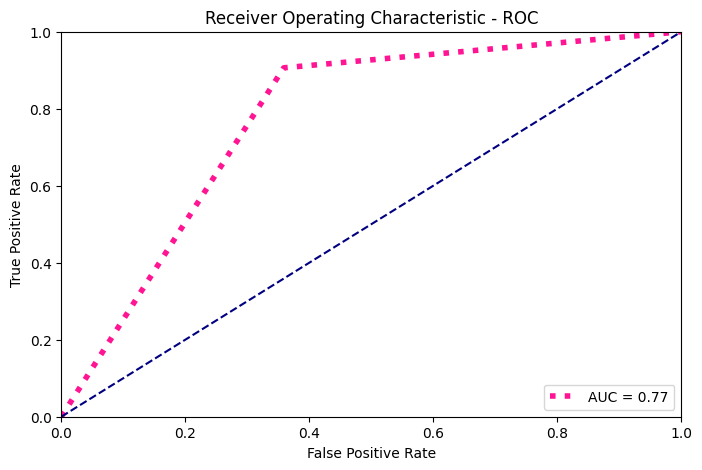

In [55]:
fpr_log_ros, tpr_log_ros, thresholds_log_ros = roc_curve(y_test, y_test_pred)

auc_log_ros = float("{:.5f}".format(auc(fpr_log_ros, tpr_log_ros)))
print(auc_log_ros)

plt.figure(figsize=(8,5))
plt.title('Receiver Operating Characteristic - ROC')
plt.plot(fpr_log_ros, tpr_log_ros, ':', linewidth=4, label = 'AUC = %0.2f' % auc_log_ros, color="deeppink", )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color="navy")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


***CẢI THIỆN MÔ HÌNH XGBOOST***

In [56]:
X_train, X_test, y_train, y_test = preprocess_data(data)

# Khởi tạo bộ phân loại
estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    seed=42
)

# Định nghĩa các tham số
parameters = {
    'max_depth': range(2, 10, 2),
    'n_estimators': range(60, 220, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='roc_auc',
    n_jobs=10,
    cv=10,
    verbose=True
)

# Thực hiện tìm kiếm tham số tối ưu
grid_search.fit(X_train, y_train)

# Hiển thị các tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Lấy bộ phân loại tốt nhất
best_estimator = grid_search.best_estimator_
print("Best estimator: ", best_estimator)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 160}
Best ROC AUC score:  0.8354416321006273
Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=160, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)


In [58]:
# Huấn luyện mô hình tốt nhất trên toàn bộ tập huấn luyện
best_estimator.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]

# Tính toán các chỉ số hiệu suất
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# In ra các chỉ số hiệu suất
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

# In riêng các giá trị precision, recall, f1-score, support
for label, metrics in report.items():
    if label not in ('accuracy', 'macro avg', 'weighted avg'):
        print(f"Class: {label}")
        print(f" Precision: {metrics['precision']:.4f}")
        print(f" Recall: {metrics['recall']:.4f}")
        print(f" F1-score: {metrics['f1-score']:.4f}")
        print(f" Support: {metrics['support']}")
        print()

ROC AUC: 0.8290
Accuracy: 0.8464
Confusion Matrix:
[[1471  622]
 [ 512 4779]]
Classification Report:
{'0': {'precision': 0.7418053454362078, 'recall': 0.7028189202102245, 'f1-score': 0.7217860647693817, 'support': 2093}, '1': {'precision': 0.8848361414552861, 'recall': 0.9032319032319033, 'f1-score': 0.8939393939393939, 'support': 5291}, 'accuracy': 0.8464247020585048, 'macro avg': {'precision': 0.813320743445747, 'recall': 0.8030254117210639, 'f1-score': 0.8078627293543879, 'support': 7384}, 'weighted avg': {'precision': 0.8442939615977656, 'recall': 0.8464247020585048, 'f1-score': 0.8451424115514151, 'support': 7384}}
Class: 0
 Precision: 0.7418
 Recall: 0.7028
 F1-score: 0.7218
 Support: 2093

Class: 1
 Precision: 0.8848
 Recall: 0.9032
 F1-score: 0.8939
 Support: 5291

